In [1]:
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (24, 10)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 18

In [2]:
with open("analysis/society-ipd-threshold-0.2.pickle", "rb") as f:
    data = pickle.load(f)

In [3]:
THRESHOLDS = [
    0.99,
    0.98,
    0.97,
    0.96,
    0.95,
    0.94,
    0.93,
    0.92,
    0.91,
    0.9,
    0.875,
    0.85,
    0.825,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
    0.2,
    0.1,
]

In [4]:
rows = []

with ProcessPoolExecutor(max_workers=8) as pool:
    futures = {
        pool.submit(get_graphs_at_thresholds, weights, THRESHOLDS): (population, lb)
        for (population, lb, t), weights_collection in data["train_weights"].items()
        for weights in weights_collection
    }

    for future in tqdm(as_completed(futures), total=len(futures)):
        population, lb = futures[future]
        Gs, edge_counts, clustering_coefficients = future.result()

        for threshold, edge_count, clustering_coefficient in zip(
            THRESHOLDS, edge_counts, clustering_coefficients
        ):
            rows.append([population, lb, threshold, edge_count, clustering_coefficient])

df = pd.DataFrame(
    rows,
    columns=[
        "population",
        "lookback",
        "threshold",
        "edge_count",
        "clustering_coefficient",
    ],
)

df

  0%|          | 0/600 [00:00<?, ?it/s]

population  lookback  threshold  edge_count  clustering_coefficient
0              16         1       0.99           0                     NaN
1              16         1       0.98           0                     NaN
2              16         1       0.97           0                     NaN
3              16         1       0.96           0                     NaN
4              16         1       0.95           0                     NaN
...           ...       ...        ...         ...                     ...
12595         512         5       0.50      129502                0.990339
12596         512         5       0.40      130499                0.997594
12597         512         5       0.30      130695                0.999076
12598         512         5       0.20      130761                0.999580
12599         512         5       0.10      130816                1.000000

[12600 rows x 5 columns]

In [5]:
df.to_csv("analysis/ipd_clustering_data_threshold_0.2.csv")

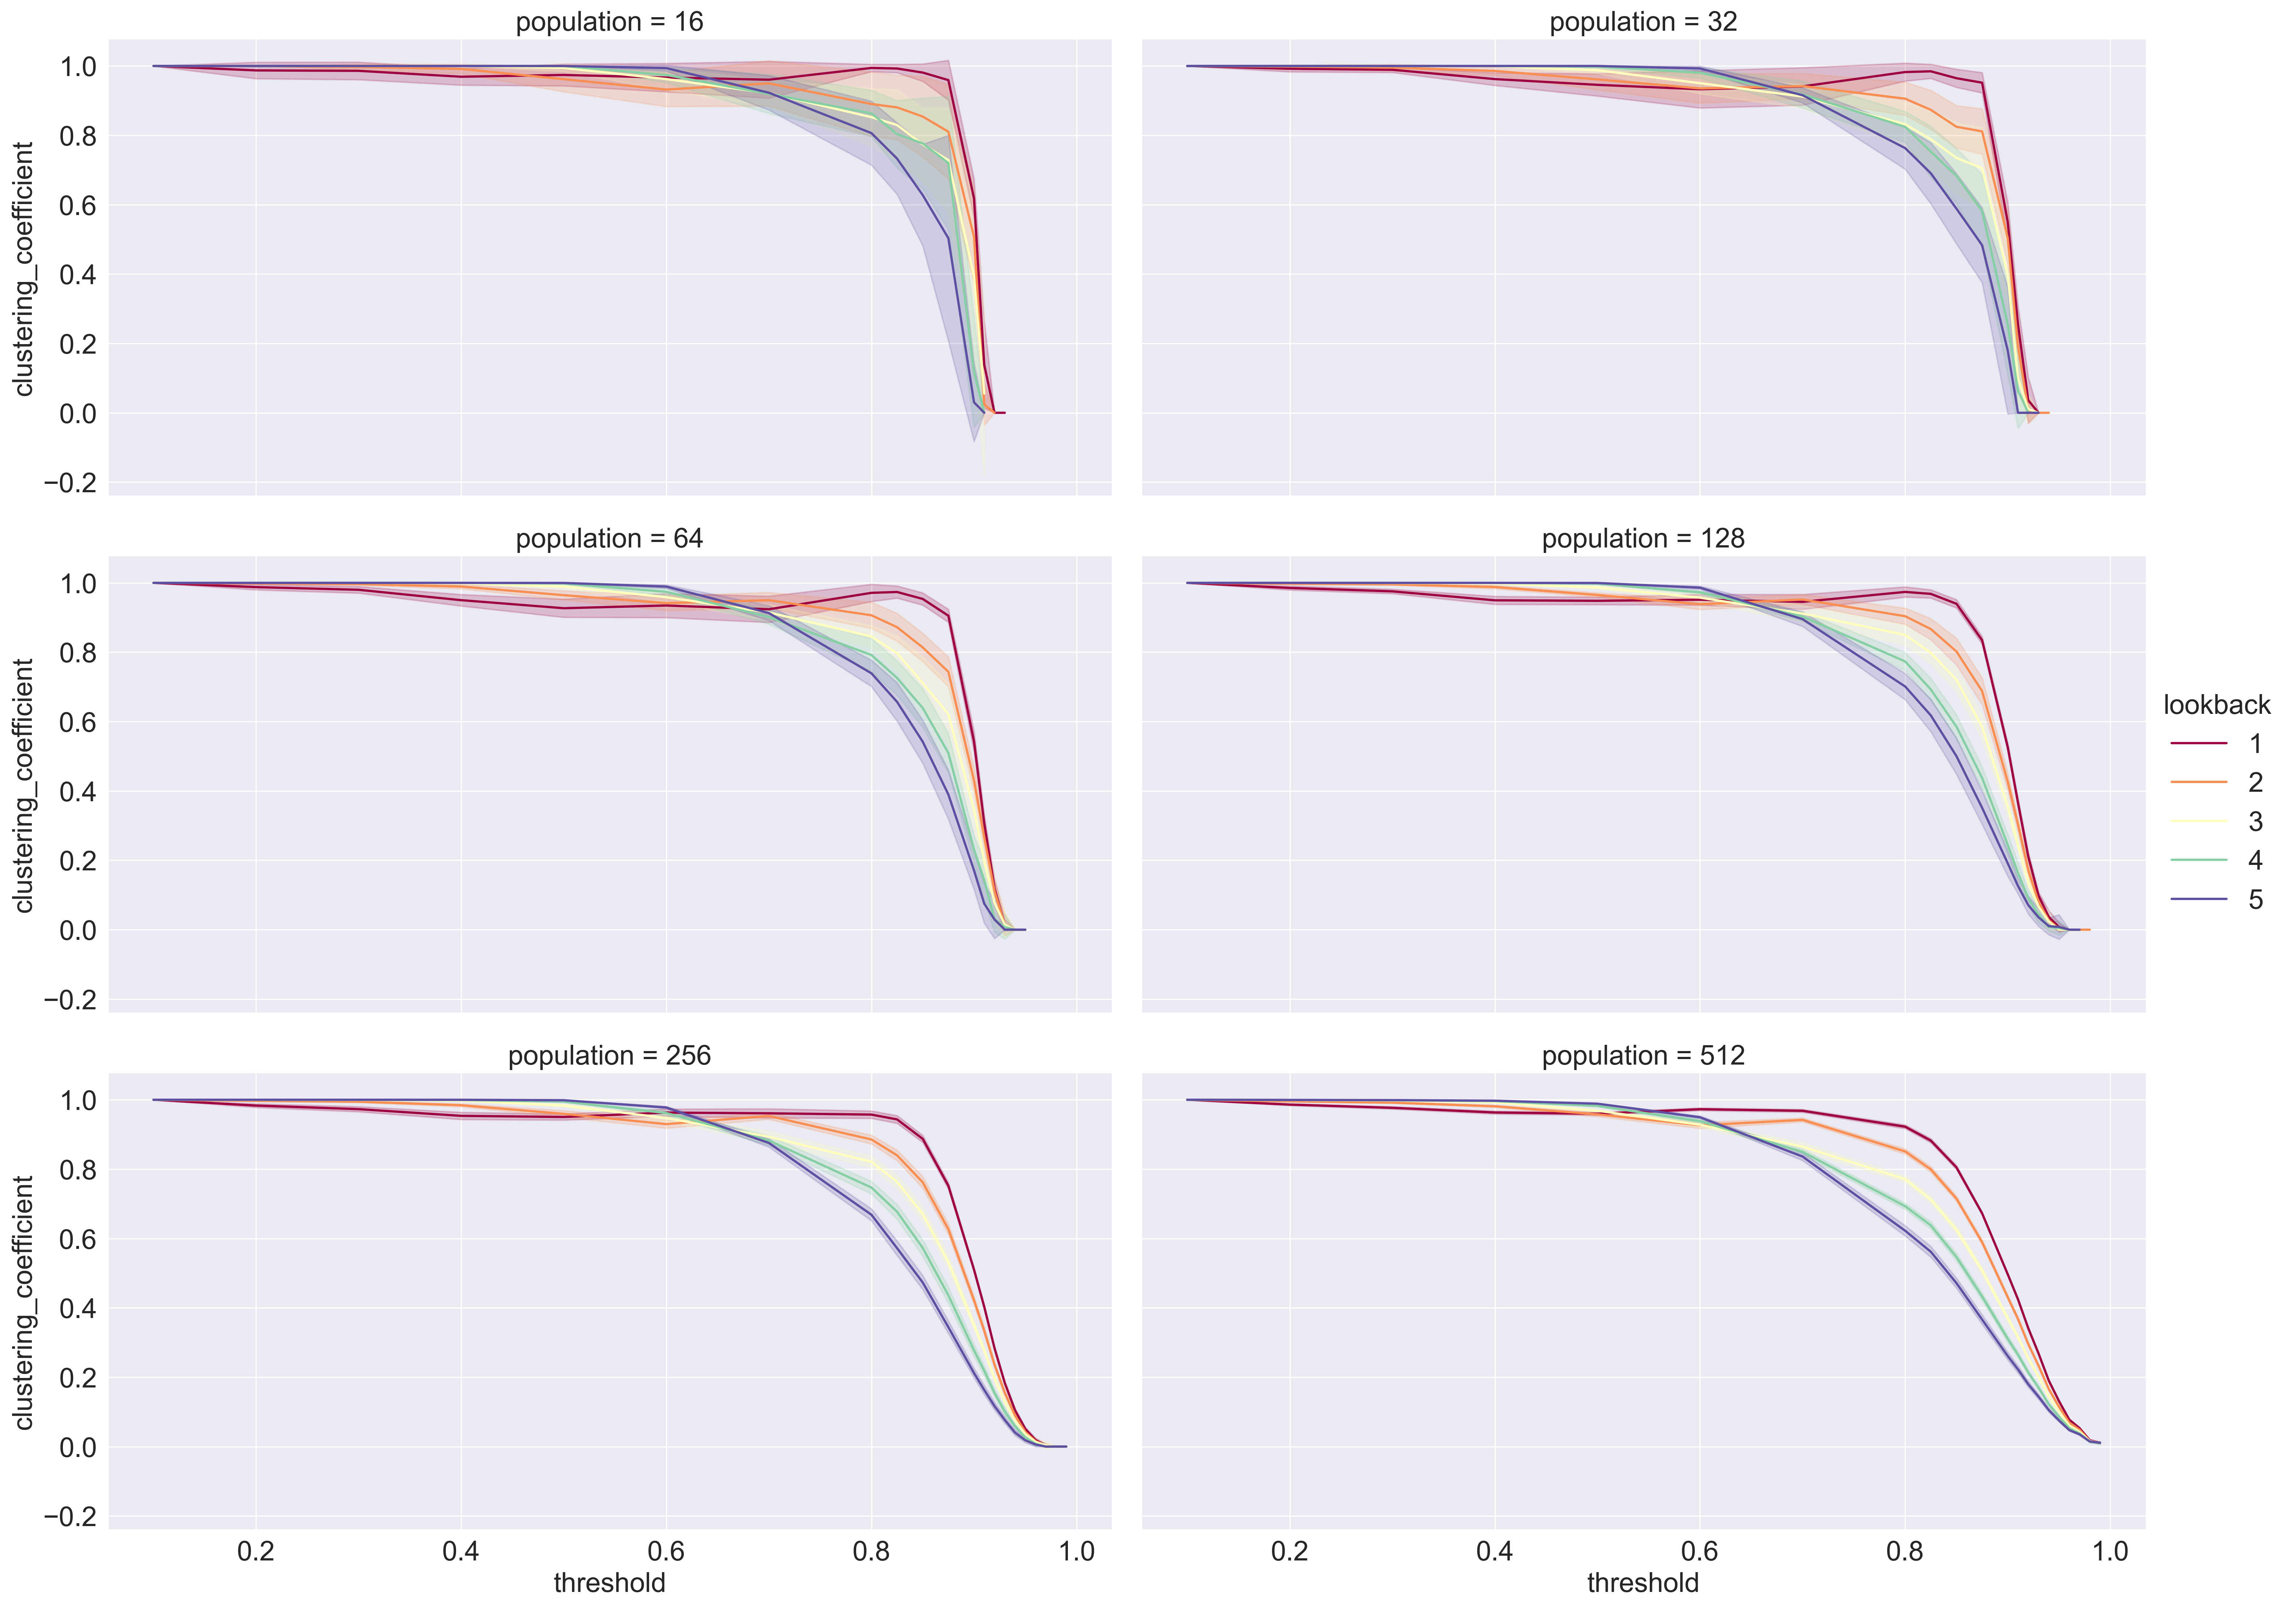

In [6]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="clustering_coefficient",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    errorbar="sd",
)

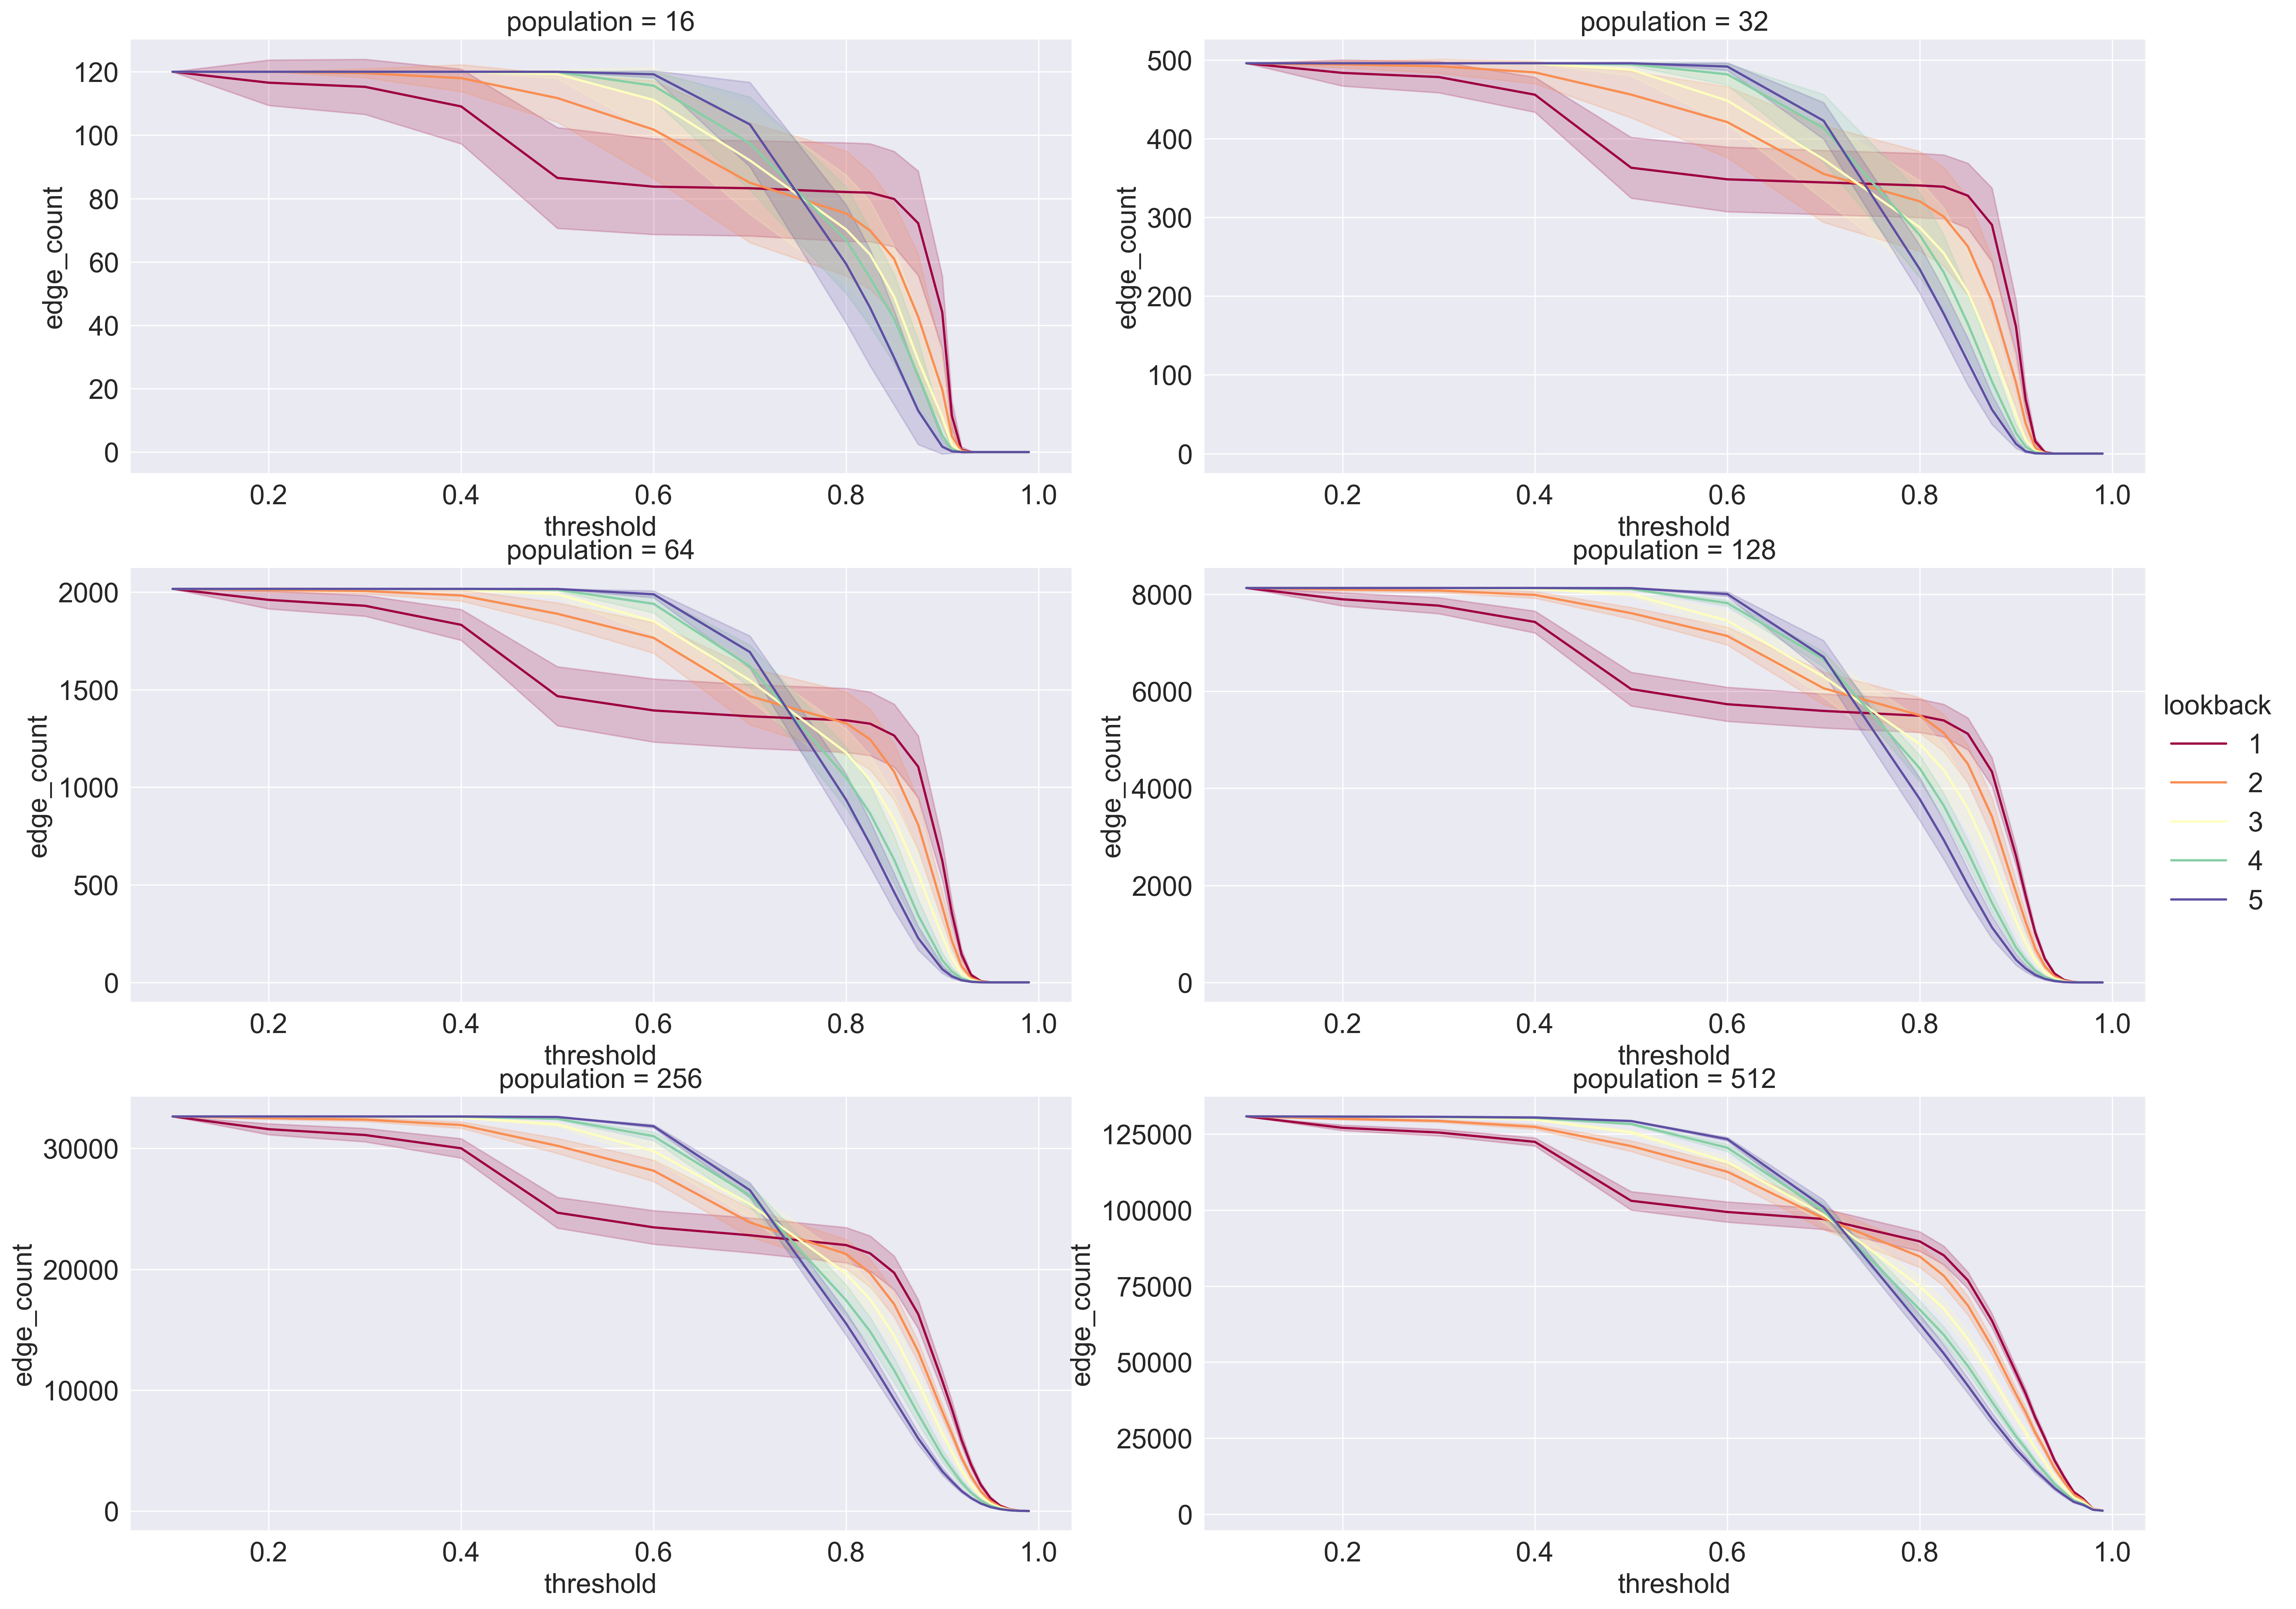

In [7]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="edge_count",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    facet_kws={"sharey": False, "sharex": False},
    errorbar="sd",
)

In [8]:
agg_df = (
    df[df["threshold"] == 0.9]
    .groupby(["population", "lookback", "threshold"])
    .agg(
        {
            "clustering_coefficient": ["mean", "std"],
        }
    )
    .round(3)
)

agg_df

clustering_coefficient       
                                                mean    std
population lookback threshold                              
16         1        0.9                        0.618  0.057
           2        0.9                        0.507  0.135
           3        0.9                        0.393  0.220
           4        0.9                        0.117  0.160
           5        0.9                        0.030  0.113
32         1        0.9                        0.550  0.056
           2        0.9                        0.504  0.073
           3        0.9                        0.398  0.090
           4        0.9                        0.255  0.145
           5        0.9                        0.179  0.183
64         1        0.9                        0.543  0.029
           2        0.9                        0.430  0.036
           3        0.9                        0.346  0.052
           4        0.9                        0.231  0.039
           5        0.9                        0.171  0.055
128        1        0.9                        0.526  0.011
           2        0.9                        0.426  0.024
           3        0.9                        0.355  0.027
           4        0.9                        0.245  0.029
           5        0.9                        0.191  0.037
256        1        0.9                        0.510  0.006
           2        0.9                        0.422  0.011
           3        0.9                        0.351  0.013
           4        0.9                        0.278  0.017
           5        0.9                        0.212  0.014
512        1        0.9                        0.497  0.003
           2        0.9                        0.431  0.006
           3        0.9                        0.370  0.009
           4        0.9                        0.311  0.009
           5        0.9                        0.261  0.011

In [9]:
agg_df2 = agg_df.reset_index()

agg_df2.pivot("population", columns="lookback")

C:\Users\jerem\AppData\Local\Temp/ipykernel_19848/4112753822.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  agg_df2.pivot("population", columns="lookback")


threshold                     clustering_coefficient                \
                                                           mean                 
lookback           1    2    3    4    5                      1      2      3   
population                                                                      
16               0.9  0.9  0.9  0.9  0.9                  0.618  0.507  0.393   
32               0.9  0.9  0.9  0.9  0.9                  0.550  0.504  0.398   
64               0.9  0.9  0.9  0.9  0.9                  0.543  0.430  0.346   
128              0.9  0.9  0.9  0.9  0.9                  0.526  0.426  0.355   
256              0.9  0.9  0.9  0.9  0.9                  0.510  0.422  0.351   
512              0.9  0.9  0.9  0.9  0.9                  0.497  0.431  0.370   

                                                             
                            std                              
lookback        4      5      1      2      3      4      5  
population                                                   
16          0.117  0.030  0.057  0.135  0.220  0.160  0.113  
32          0.255  0.179  0.056  0.073  0.090  0.145  0.183  
64          0.231  0.171  0.029  0.036  0.052  0.039  0.055  
128         0.245  0.191  0.011  0.024  0.027  0.029  0.037  
256         0.278  0.212  0.006  0.011  0.013  0.017  0.014  
512         0.311  0.261  0.003  0.006  0.009  0.009  0.011

In [10]:
for population, row in agg_df2.pivot("population", columns="lookback").iterrows():
    print(
        population,
        *(
            f"${mean:.3f} \pm {std:.3f}$"
            for mean, std in zip(
                row["clustering_coefficient"]["mean"],
                row["clustering_coefficient"]["std"],
            )
        ),
        sep="\t&\t",
        end=" \\\\\n",
    )

16	&	$0.618 \pm 0.057$	&	$0.507 \pm 0.135$	&	$0.393 \pm 0.220$	&	$0.117 \pm 0.160$	&	$0.030 \pm 0.113$ \\
32	&	$0.550 \pm 0.056$	&	$0.504 \pm 0.073$	&	$0.398 \pm 0.090$	&	$0.255 \pm 0.145$	&	$0.179 \pm 0.183$ \\
64	&	$0.543 \pm 0.029$	&	$0.430 \pm 0.036$	&	$0.346 \pm 0.052$	&	$0.231 \pm 0.039$	&	$0.171 \pm 0.055$ \\
128	&	$0.526 \pm 0.011$	&	$0.426 \pm 0.024$	&	$0.355 \pm 0.027$	&	$0.245 \pm 0.029$	&	$0.191 \pm 0.037$ \\
256	&	$0.510 \pm 0.006$	&	$0.422 \pm 0.011$	&	$0.351 \pm 0.013$	&	$0.278 \pm 0.017$	&	$0.212 \pm 0.014$ \\
512	&	$0.497 \pm 0.003$	&	$0.431 \pm 0.006$	&	$0.370 \pm 0.009$	&	$0.311 \pm 0.009$	&	$0.261 \pm 0.011$ \\


C:\Users\jerem\AppData\Local\Temp/ipykernel_19848/339049292.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  for population, row in agg_df2.pivot("population", columns="lookback").iterrows():
